In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [326]:
data = pd.read_csv("data.csv")
data.head()

,EMBL_transcript_id,cDNA_length,cds_length,exons_nr,5_MAR_presence,3_MAR_presence,5_polyA_18_presence,5_CCGNN_2_5_presence,perc_go_hk_match,perc_go_ts_match,is_hk
0,ENST00000274311,2918.0,1158.0,3.0,no,no,no,yes,0.1,0.200000,NaN
1,ENST00000282588,4795.0,3540.0,29.0,no,no,no,yes,0.1,0.200000,NaN
2,ENST00000274311,2918.0,1158.0,3.0,no,no,no,yes,0.1,0.200000,NaN
3,ENST00000282588,4795.0,3540.0,29.0,no,no,no,yes,0.1,0.200000,NaN
4,ENST00000337416,4551.0,1656.0,18.0,no,yes,no,no,0.0,0.111111,NaN


In [327]:
data.describe()

,cDNA_length,cds_length,exons_nr,perc_go_hk_match,perc_go_ts_match
count,35164.000000,35164.000000,20568.000000,25957.000000,25957.000000
mean,2439.950432,1484.058583,6.568748,0.036278,0.222914
std,2012.944961,1502.566846,8.333126,0.131669,0.253348
min,45.000000,45.000000,1.000000,0.000000,0.000000
25%,1168.000000,642.000000,1.000000,0.000000,0.000000
50%,2047.000000,1119.000000,3.000000,0.000000,0.166667
75%,3185.250000,1821.000000,9.000000,0.000000,0.363636
max,99631.000000,98385.000000,118.000000,1.000000,1.000000


In [328]:
data.loc[data["5_MAR_presence"] == "no", "5_MAR_presence"] = 0.0
data.loc[data["5_MAR_presence"] == "yes", "5_MAR_presence"] = 1.0
data.loc[data["3_MAR_presence"] == "no", "3_MAR_presence"] = 0.0
data.loc[data["3_MAR_presence"] == "yes", "3_MAR_presence"] = 1.0
data.loc[data["5_polyA_18_presence"] == "no", "5_polyA_18_presence"] = 0.0
data.loc[data["5_polyA_18_presence"] == "yes", "5_polyA_18_presence"] = 1.0
data.loc[data["5_CCGNN_2_5_presence"] == "no", "5_CCGNN_2_5_presence"] = 0.0
data.loc[data["5_CCGNN_2_5_presence"] == "yes", "5_CCGNN_2_5_presence"] = 1.0
data.loc[data["is_hk"] == "no", "is_hk"] = 0.0
data.loc[data["is_hk"] == "yes", "is_hk"] = 1.0
del data["EMBL_transcript_id"]

data["5_MAR_presence"] = data["5_MAR_presence"].astype(float)
data["3_MAR_presence"] = data["3_MAR_presence"].astype(float)
data["5_polyA_18_presence"] = data["5_polyA_18_presence"].astype(float)
data["5_CCGNN_2_5_presence"] = data["5_CCGNN_2_5_presence"].astype(float)

In [329]:
data.head()

,cDNA_length,cds_length,exons_nr,5_MAR_presence,3_MAR_presence,5_polyA_18_presence,5_CCGNN_2_5_presence,perc_go_hk_match,perc_go_ts_match,is_hk
0,2918.0,1158.0,3.0,0.0,0.0,0.0,1.0,0.1,0.200000,NaN
1,4795.0,3540.0,29.0,0.0,0.0,0.0,1.0,0.1,0.200000,NaN
2,2918.0,1158.0,3.0,0.0,0.0,0.0,1.0,0.1,0.200000,NaN
3,4795.0,3540.0,29.0,0.0,0.0,0.0,1.0,0.1,0.200000,NaN
4,4551.0,1656.0,18.0,0.0,1.0,0.0,0.0,0.0,0.111111,NaN


- How many items are NaN in the is hk column?
- How many items are known housekeeping genes?
- How many items are known tissue specific genes?

In [43]:
print("NaN %s" % len(data[data["is_hk"].isnull()]))
print("Housekeeping %s" % len(data[data["is_hk"] == 1]))
print("Specific %s" % len(data[data["is_hk"] == 0]))

NaN 46459
Housekeeping 103
Specific 667


In [332]:
def split_train_test(data):
    split = (int) (len(data) * 0.9)
    return data[0:split], data[split:]

def split_data(data):
    # Shuffle data
    data = data.sample(frac = 1)
    
    # train_set, test_set
    hk_yes = data[data["is_hk"] == 1]
    hk_no = data[data["is_hk"] == 0]
    
    train_yes, test_yes = split_train_test(hk_yes)
    train_no , test_no  = split_train_test(hk_no)
    
    train_set = train_yes
    train_set = train_set.append(train_no)
    train_set = train_set.sample(frac = 1)
    
    test_set = test_yes
    test_set = test_set.append(test_no)
    test_set = test_set.sample(frac = 1)
    
    # unsup_train_set
    unsup_train_set = data[data["is_hk"].isnull()]
    
    # sup_train_set
    sup_train_set = data[data["is_hk"].notnull()]
    
    return train_set, test_set, unsup_train_set, sup_train_set

train_set, test_set, unsup_train_set, sup_train_set = split_data(data)

In [322]:
def bin_plot(hist, bin_edge, only_large = False, title = None):
    # make sure to import matplotlib.pyplot as plt
    # plot the histogram
    plt.fill_between(bin_edge.repeat(2)[1:-1],hist.repeat(2),facecolor="steelblue")
    if title is not None:
        plt.title(title)
    plt.show()
    
    if only_large:
        return None
    
    # plot the first 100 bins only
    plt.fill_between(bin_edge.repeat(2)[1:100],hist.repeat(2)[1:100],facecolor="steelblue")
    plt.show()
    # plot the first 500 bins only
    plt.fill_between(bin_edge.repeat(2)[1:500],hist.repeat(2)[1:500],facecolor="steelblue")
    plt.show()

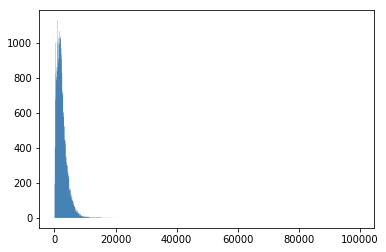

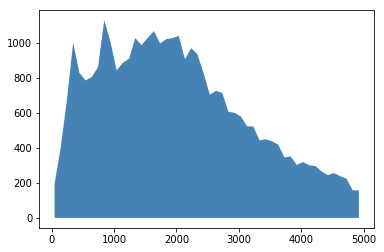

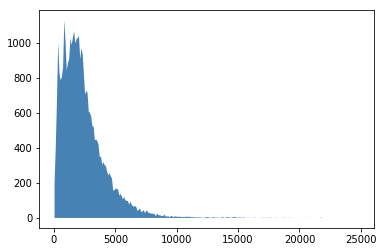

In [315]:
# remove NaN values
train_set_clength_no_nan = data["cDNA_length"][~np.isnan(data["cDNA_length"])]
# bin the data into 1000 equally spaced bins
# hist is the count for each bin
# bin_edge is the edge values of the bins
hist, bin_edge = np.histogram(train_set_clength_no_nan,1000)
bin_plot(hist, bin_edge)

How many bins have zero counts?

In [286]:
print("Total %s" % len(hist))
print("Zeros %s" % sum(hist == 0))

Total 1000
Zeros 823


**cDNA Density Plot**

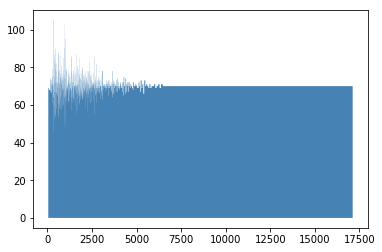

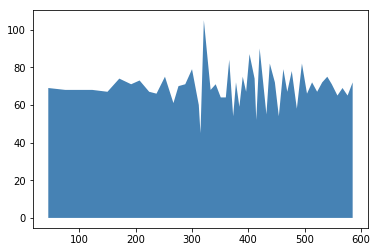

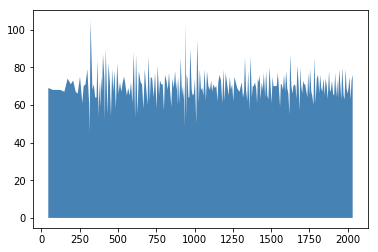

In [312]:
train_set_clength_no_nan_sorted = data["cDNA_length"][data["cDNA_length"].notnull()].sort_values()

bin_edge = np.unique(train_set_clength_no_nan_sorted[0::70])
hist = np.bincount(np.digitize(train_set_clength_no_nan_sorted, bin_edge))
hist = hist[1:-1]
bin_plot(hist, bin_edge)

**CDS Density Plot**

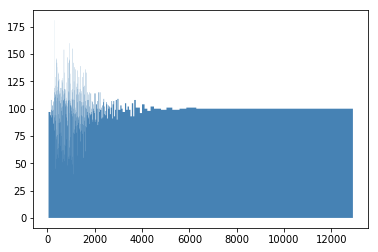

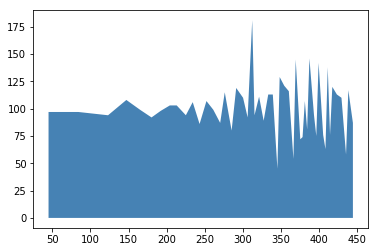

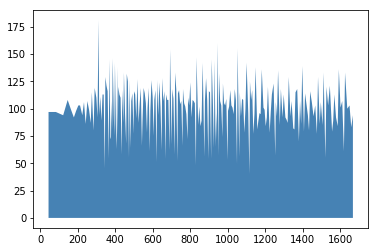

In [295]:
train_set_clength_no_nan_sorted = data["cds_length"][data["cds_length"].notnull()].sort_values()

bin_edge = np.unique(train_set_clength_no_nan_sorted[0::100])
hist = np.bincount(np.digitize(train_set_clength_no_nan_sorted, bin_edge))
hist = hist[1:-1]
bin_plot(hist, bin_edge)

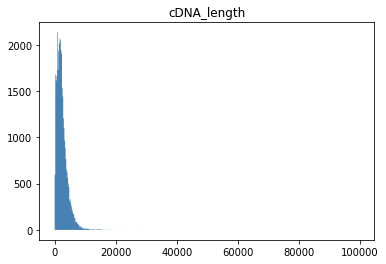

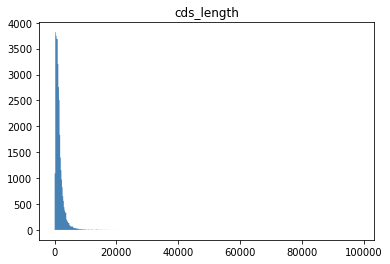

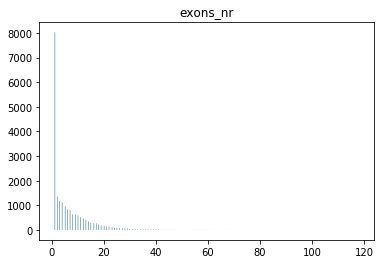

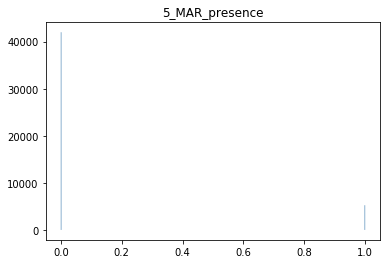

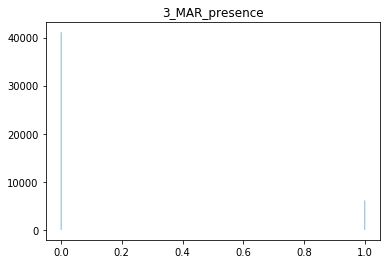

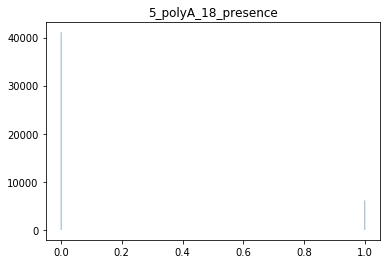

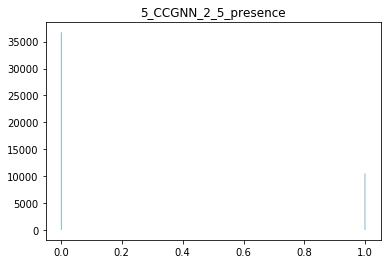

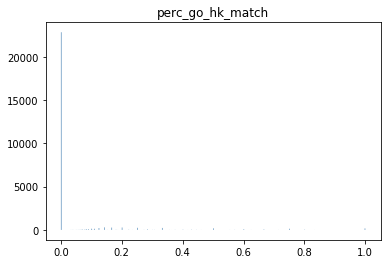

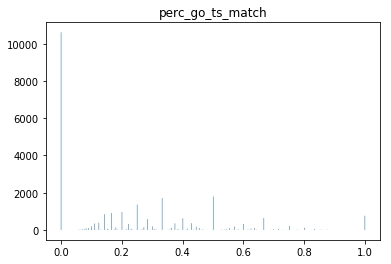

In [339]:
for feature in list(train_set):
    if feature == "is_hk":
        continue
    train_set_clength_no_nan = data[feature][~np.isnan(data[feature])]
    hist, bin_edge = np.histogram(train_set_clength_no_nan, 500)
    bin_plot(hist, bin_edge, only_large=True, title=feature)

In [333]:
train_set.dtypes

cDNA_length             float64
cds_length              float64
exons_nr                float64
5_MAR_presence          float64
3_MAR_presence          float64
5_polyA_18_presence     float64
5_CCGNN_2_5_presence    float64
perc_go_hk_match        float64
perc_go_ts_match        float64
is_hk                    object
dtype: object